# The market order itself is information
Urgency = Risk Perception + Time Value
Market Order = Willingness to Pay Spread
Therefore: Market Order ≈ Strong Conviction or Forced Action

In [ ]:
"""
Ok write me a function that accepts a time date to and from where the to is defaulted to the current day.

The function will firstly check your downloaded files. What we are trying to do is progromatically download data from a specific time period from binance.

The data is stored in two formats the monthly format and the day format. The only time day data should be downloaded is when the current months is not avalible due to a complete month not being avalible. The two urls are:

monthly: `https://data.binance.vision/?prefix=data/spot/monthly/aggTrades/DOGEBTC/`
daily: `https://data.binance.vision/?prefix=data/spot/daily/aggTrades/DOGEBTC/`

At these urls you have files eg for monthly would look like:
`DOGEBTC-aggTrades-2025-02.zip`
 and for daily:
`DOGEBTC-aggTrades-2025-02-18.zip`

The files are consistently named `[asset]-aggTrades-[YYYY]-[MM]{-DD}.zip

These zip files contain a single csv named the same thing but with the `.csv` extension.

I want you to write a function that
"""


from datetime import datetime, date
from datetime import timedelta
from pathlib import Path
from typing import Final, Literal, TypedDict
import requests
import polars as pl
from urllib.parse import urlparse
from zipfile import ZipFile
from tempfile import TemporaryDirectory

DATA_DIR: Final[Path] = Path("data")

now = datetime.now()

from_ = date(2024, 10, 12)
print(f"{from_ = }")
to_ = now.date()
print(f"{to_ = }")
# Start function



class Dates(TypedDict):
    days: list[date]
    month: list[date]


def get_dates(from_: date, to_: date) -> Dates:
    if to_ == datetime.now().date():
        to_ = to_ - timedelta(days=1)
    days: list[date] = [date(to_.year, to_.month, d) for d in range(to_.day, 0, -1)]

    def subtract_month(d: date) -> date:
        if d.month == 1:
            return date(d.year - 1, 12, 1)
        return date(d.year, d.month - 1, 1)

    current = subtract_month(date(to_.year, to_.month, 1))
    start = date(from_.year, from_.month, 1)
    months: list[date] = []
    while current >= start:
        months.append(current)
        current = subtract_month(current)
    return {"days": days, "month": months}


dates, months = get_dates(from_, to_)


def get_url(
    asset: str, d: date, *, scope: Literal["monthly", "daily"] = False, type: Literal["spot"] = "spot"
) -> str:

    return f"https://data.binance.vision/data/{type}/{scope}/aggTrades/{asset}/{asset}-aggTrades-{d.year}-{d.month:02}{f'-{d.day:02}' if scope=='daily' else ''}.zip"


def convert_csv_to_parquet(csv: Path):
    asset = csv.stem.split("-")[0]
    asset_path = DATA_DIR / asset
    asset_path.mkdir(exist_ok=True)
    output_parquet = asset_path /  csv.with_suffix(".parquet").name
    print("Converting csv to parquet")
    pl.scan_csv(
            csv,
            schema=pl.Schema(
                {
                    "tradeId": pl.UInt64(),
                    "price": pl.Float64(),
                    "quantity": pl.Float64(),
                    "firstTradeId": pl.UInt64(),
                    "lastTradeId": pl.UInt64(),
                    "timestamp": pl.UInt64(),
                    "is_passive_buy": pl.Boolean(),
                    "best_match": pl.Boolean(),
                }
            ),
        ).with_columns(pl.col("timestamp").cast(pl.Datetime)).select(
            "tradeId", "price", "quantity", "timestamp", "is_passive_buy"
        ).sink_parquet(output_parquet, compression_level=22)
    print(f"Converted '{csv.name}' to {output_parquet.name}")

def download_zip(
    asset: str, d: date, *, scope: Literal["monthly", "daily"] = "daily", type: Literal["spot"] = "spot"
):
    # Download the zip to a tempdir and extract the csv to the temp dir.
    url = get_url(asset, d, scope=scope, type=type)
    print(f"{url = }")
    zip_name = Path(url.split("/")[-1])
    print(f"{zip_name = }")
    with TemporaryDirectory() as tmpdir:
        print(f"{tmpdir = }")
        r = requests.get(url)
        r.raise_for_status()
        if not r.content.startswith(b'PK'):
            raise ValueError("Downloaded content does not appear to be a valid zip file.")
        zip_file = Path(tmpdir) / zip_name
        with zip_file.open("wb") as f:
            f.write(r.content)
        print(f"Downloaded {zip_name}")
        print(f"Extracting {zip_file}")
        with ZipFile(zip_file) as zip:
            zip.extractall(tmpdir)
            csv_name = zip.namelist()[0]
            convert_csv_to_parquet(Path(tmpdir) / csv_name)

def download_data(asset: str, from_: date, to_: date):
    dates = get_dates(from_, to_)
    for d in dates["days"]:
        print(f"Download {asset} {d}")
        download_zip(asset, d)
    for d in dates["month"]:
        download_zip(asset, d, scope="monthly")

from_ = datetime.date(2024, 10, 12)
to_ = datetime.date(2025, 2, 19)


In [134]:
download_data("DOGEBTC", from_, to_)

Download DOGEBTC 2025-02-18
url = 'https://data.binance.vision/data/spot/daily/aggTrades/DOGEBTC/DOGEBTC-aggTrades-2025-02-18.zip'
zip_name = PosixPath('DOGEBTC-aggTrades-2025-02-18.zip')
tmpdir = '/var/folders/cs/b5nrw9r531s_zxp5gwn2k5w00000gn/T/tmp_y6lpqyn'
Downloaded DOGEBTC-aggTrades-2025-02-18.zip
Extracting /var/folders/cs/b5nrw9r531s_zxp5gwn2k5w00000gn/T/tmp_y6lpqyn/DOGEBTC-aggTrades-2025-02-18.zip
zip_file.exists() = True
Converting csv to parquet


/var/folders/cs/b5nrw9r531s_zxp5gwn2k5w00000gn/T/ipykernel_56157/3592353325.py:102: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  ).sink_parquet(output_parquet, compression_level=22)


Converted 'DOGEBTC-aggTrades-2025-02-18.csv' to DOGEBTC-aggTrades-2025-02-18.parquet
Download DOGEBTC 2025-02-17
url = 'https://data.binance.vision/data/spot/daily/aggTrades/DOGEBTC/DOGEBTC-aggTrades-2025-02-17.zip'
zip_name = PosixPath('DOGEBTC-aggTrades-2025-02-17.zip')
tmpdir = '/var/folders/cs/b5nrw9r531s_zxp5gwn2k5w00000gn/T/tmpw6e78tdx'
Downloaded DOGEBTC-aggTrades-2025-02-17.zip
Extracting /var/folders/cs/b5nrw9r531s_zxp5gwn2k5w00000gn/T/tmpw6e78tdx/DOGEBTC-aggTrades-2025-02-17.zip
zip_file.exists() = True
Converting csv to parquet
Converted 'DOGEBTC-aggTrades-2025-02-17.csv' to DOGEBTC-aggTrades-2025-02-17.parquet
Download DOGEBTC 2025-02-16
url = 'https://data.binance.vision/data/spot/daily/aggTrades/DOGEBTC/DOGEBTC-aggTrades-2025-02-16.zip'
zip_name = PosixPath('DOGEBTC-aggTrades-2025-02-16.zip')
tmpdir = '/var/folders/cs/b5nrw9r531s_zxp5gwn2k5w00000gn/T/tmpcddlvf54'
Downloaded DOGEBTC-aggTrades-2025-02-16.zip
Extracting /var/folders/cs/b5nrw9r531s_zxp5gwn2k5w00000gn/T/tmpcdd

In [ ]:
import polars as pl
import polars.selectors as cs
from pathlib import Path
import seaborn as sns
from typing import overload
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
import polars_talib as plta
import numpy as np

csv = Path("binance/data/BTCUSDT-aggTrades-2025-01.zip")
parquet = csv.with_suffix(".parquet")

# glob BTCUSDT-aggTrades

glob = Path("binance/data").glob("BTCUSDT-aggTrades-*")

def get_data(asset: str, from_: datetime, to_: datetime = datetime.now()) -> pl.LazyFrame:
    to_ = to_.date()
    # First work out the date range and what files we need to read
    if to_ == datetime.now().date():
        to_ = to_ - timedelta(days=1)
    date_range = [from_ + timedelta(days=i) for i in range((to_ - from_).days + 1)]





def read_data(asset: str) -> pl.LazyFrame:

    data_path = Path("binance/data")
    file_root = f"{asset}-aggTrades-*"

    zips = list(data_path.glob(f"{file_root}.zip"))

    for zip in zips:
        if zip.with_suffix(".csv").exists():
            continue




    if not parquet.exists():
        pl.scan_csv(
            csv,
            schema=pl.Schema(
                {
                    "tradeId": pl.UInt64(),
                    "price": pl.Float64(),
                    "quantity": pl.Float64(),
                    "firstTradeId": pl.UInt64(),
                    "lastTradeId": pl.UInt64(),
                    "timestamp": pl.UInt64(),
                    "is_passive_buy": pl.Boolean(),
                    "best_match": pl.Boolean(),
                }
            ),
        ).with_columns(pl.col("timestamp").cast(pl.Datetime)).select(
            "tradeId", "price", "quantity", "timestamp", "is_passive_buy"
        ).sink_parquet(parquet)
        #.collect(new_streaming=True).write_parquet(parquet)
        print("Wrote parquet")
    return pl.scan_parquet(parquet)  # .with_columns(pl.col("maker").cast(pl.UInt8))


df = read_data(csv)


/var/folders/cs/b5nrw9r531s_zxp5gwn2k5w00000gn/T/ipykernel_56157/1896244400.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  ).sink_parquet(parquet)


ComputeError: could not parse `·j���M����KJ0�٭���Zϰ��f4P�=��}ö�6����i}�~��C` as dtype `u64` at column 'tradeId' (column number 1)

The current offset in the file is 42519863 bytes.

You might want to try:
- increasing `infer_schema_length` (e.g. `infer_schema_length=10000`),
- specifying correct dtype with the `schema_overrides` argument
- setting `ignore_errors` to `True`,
- adding `·j���M����KJ0�٭���Zϰ��f4P�=��}ö�6����i}�~��C` to the `null_values` list.

Original error: ```remaining bytes non-empty```

In [11]:
@overload
def slice_df(
    df: pl.DataFrame, *, dt: datetime | None = None, delta: timedelta
) -> pl.DataFrame: ...


@overload
def slice_df(
    df: pl.LazyFrame, *, dt: datetime | None = None, delta: timedelta
) -> pl.LazyFrame: ...


def slice_df(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    delta: timedelta,
    dt: datetime | None = None,
) -> pl.DataFrame | pl.LazyFrame:
    if dt is None:
        dt = df.lazy().select(pl.col("timestamp")).collect().sample(1).item()
        print(dt)

    return df.filter(pl.col("timestamp").is_between(dt, dt + delta, closed="left"))


@overload
def build_volume_distribution(
    df: pl.DataFrame, *, bucket_size: int = 20
) -> pl.DataFrame: ...


@overload
def build_volume_distribution(
    df: pl.LazyFrame, *, bucket_size: int = 20
) -> pl.LazyFrame: ...


def build_volume_distribution(
    df: pl.DataFrame | pl.LazyFrame, *, bucket_size: int = 20
) -> pl.DataFrame | pl.LazyFrame:
    price = "price"
    quantity = "quantity"
    schema = df.collect_schema()
    if price and quantity not in schema:
        price = "vwap"
        quantity = "aggr_volume_total"

    return (
        df.with_columns(
            price_bucket=(pl.col(price) / bucket_size).floor() * bucket_size
        )
        .group_by(["price_bucket", "is_passive_buy"])
        .agg(
            aggr_volume_total=pl.col(quantity).sum(),
            count=pl.col(price).count(),
            vwap=((pl.col(price) * pl.col(quantity)).sum() / pl.col(quantity).sum()),
            average_volume=pl.col(quantity).mean(),
            average_price=pl.col(price).mean(),
        )
        .sort("price_bucket", descending=True)
    )


# How could I get a weighted mean of the price, where when aggregating the price, its weighted by the quantity?
@overload
def analyze_trade_aggression(
    df: pl.DataFrame,
    *,
    every: str | timedelta = "10s",
    group_by: list[str] | None = ["is_passive_buy"],
) -> pl.DataFrame: ...


@overload
def analyze_trade_aggression(
    df: pl.LazyFrame,
    *,
    every: str | timedelta = "10s",
    group_by: list[str] | None = ["is_passive_buy"],
) -> pl.LazyFrame: ...


def analyze_trade_aggression(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    every: str | timedelta = "10s",
    group_by: list[str] | None = ["is_passive_buy"],
) -> pl.DataFrame | pl.LazyFrame:
    window_size = 6  # Define your window size
    alpha = 0.1  # Choose your decay rate

    # Create weights so that the most recent value (last in the window) gets the highest weight.
    weights = np.exp(-alpha * np.arange(window_size)[::-1])
    weights: list[float] = weights / weights.sum()  # Normalize the weights to sum to 1

    return (
        df.group_by_dynamic("timestamp", every=every, group_by=group_by)
        .agg(
            total_value=(pl.col("price") * pl.col("quantity")).sum(),
            aggr_volume_total=pl.col("quantity").sum(),
            vwap=(
                (pl.col("price") * pl.col("quantity")).sum() / pl.col("quantity").sum()
            ),
            first_trade=pl.col("timestamp").first(),
            last_trade=pl.col("timestamp").last(),
            open=pl.col("price").first(),
            close=pl.col("price").last(),
            high=pl.col("price").max(),
            low=pl.col("price").min(),
        )
        .sort("timestamp")
        .with_columns(
            aggr_volume_moving_avg=pl.col("aggr_volume_total")
            .rolling_mean(window_size)
            .over(group_by),
            aggr_volume_moving_avg_weighted=pl.col("aggr_volume_total")
            .rolling_mean(window_size, weights=weights)
            .over(group_by),
        )
    )


@overload
def compute_market_metrics(
    df: pl.DataFrame,
    *,
    every: str | timedelta = "10s",
) -> pl.DataFrame: ...


@overload
def compute_market_metrics(
    df: pl.LazyFrame,
    *,
    every: str | timedelta = "10s",
) -> pl.LazyFrame: ...


def compute_market_metrics(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    every: str | timedelta = "10s",
) -> pl.DataFrame | pl.LazyFrame:
    def fpb(col_name: str, *, buy: bool = False) -> pl.Expr:
        """Filter passive buy trades. A passive buy is essentially an aggressive sell"""
        if buy:
            return (
                pl.when(pl.col("is_passive_buy").not_())
                .then(pl.col(col_name))
                .otherwise(0)
                .sum()
            )
        else:
            return (
                pl.when(pl.col("is_passive_buy"))
                .then(pl.col(col_name))
                .otherwise(0)
                .sum()
            )

    return (
        df.group_by_dynamic("timestamp", every=every)
        .agg(
            total_value=pl.col("total_value").sum(),
            aggr_volume_total=pl.col("aggr_volume_total").sum(),
            open=pl.col("open").get(pl.col("first_trade").arg_min()),
            close=pl.col("close").get(pl.col("last_trade").arg_max()),
            high=pl.col("high").max(),
            low=pl.col("low").min(),
            vwap=(pl.col("total_value")).sum() / pl.col("aggr_volume_total").sum(),
            # Does this impact vary at different price levels?
            # How does it relate to overall market volatility?
            # Could we use this to identify weak price levels?
            price_impact=(
                (fpb("total_value", buy=True) / fpb("aggr_volume_total", buy=True))
                - (fpb("total_value") / fpb("aggr_volume_total"))
            ).fill_nan(0),
            aggr_volume_delta=(
                fpb("aggr_volume_total", buy=True) - fpb("aggr_volume_total")
            ),
            sustained_aggr_delta=(
                fpb("aggr_volume_total", buy=True) - fpb("aggr_volume_total")
            ),
            sustained_aggr_delta_weighted=(
                fpb("aggr_volume_moving_avg_weighted", buy=True) - fpb("aggr_volume_moving_avg_weighted")
            ),
        )
        .sort("timestamp")
        .with_columns(
            plta.bbands(real=pl.col("vwap"), timeperiod=200)
            .struct.rename_fields(["bb_upper", "bb_basis", "bb_lower"])
            .struct.unnest(),
            ema_800=plta.ema(pl.col("vwap"), timeperiod=800),
            ema_200=plta.ema(pl.col("vwap"), timeperiod=200),
            impact_efficiency=(pl.col("price_impact") / pl.col("aggr_volume_total")),
            aggr_volume_zscore=(
                (
                    pl.col("aggr_volume_delta")
                    - pl.col("aggr_volume_delta").rolling_mean(800)
                )
                / pl.col("aggr_volume_delta").rolling_std(800)
            ),
            rolling_vol_z_score=(
                (
                    pl.col("sustained_aggr_delta")
                    - pl.col("sustained_aggr_delta").rolling_mean(800)
                )
                / pl.col("sustained_aggr_delta").rolling_std(800)
            ),
            spread_z_score=(
                (pl.col("price_impact") - pl.col("price_impact").rolling_mean(800))
                / pl.col("price_impact").rolling_std(800)
            ),
        )
        # Instead of just z-score thresholds, consider:
        #   Clustering of aggressive trades
        #   Volume persistence (how long does high volume last?)
        #   Price reaction to volume spikes
        .with_columns(
            volume_imbalance=pl.when(pl.col("aggr_volume_zscore") > 4)
            .then(1)
            .when(pl.col("aggr_volume_zscore") < -4)
            .then(-1)
            .otherwise(0)
            .cast(pl.Int8),
            sustained_volume_imbalance=pl.when(pl.col("rolling_vol_z_score") > 4)
            .then(1)
            .when(pl.col("rolling_vol_z_score") < -4)
            .then(-1)
            .otherwise(0)
            .cast(pl.Int8),
            diverged_spread=pl.when(pl.col("spread_z_score") > 4)
            .then(1)
            .when(pl.col("spread_z_score") < -4)
            .then(-1)
            .otherwise(0)
            .cast(pl.Int8),
            bb_spread=(pl.col("bb_upper") - pl.col("bb_lower")),
        )
        .with_columns(
            bb_z_score=(
                (pl.col("bb_spread") - pl.col("bb_spread").rolling_mean(800))
                / pl.col("bb_spread").rolling_std(800)
            ),
            # Detect volume clusters
            # aggressive_buy_cluster=(
            #    ( ((pl.col("volume_imbalance") > 0).rolling_sum(3)) >= 2)
            # ),
            # Price impact
            # Sequence analysis
            consecutive_aggressive=(pl.col("volume_imbalance").rolling_sum(10).abs()),
        )
        # How does aggressive trade behavior change in different volatility regimes?
        # Should we adjust our volume z-score thresholds based on volatility?
        # Are certain patterns more reliable in specific volatility conditions?
        .with_columns(
            high_volatility=pl.col("bb_z_score").abs() > 2,
        )
    )


@overload
def normalize_volume_intraday(df: pl.DataFrame, window: int = 6) -> pl.DataFrame: ...


@overload
def normalize_volume_intraday(df: pl.LazyFrame, window: int = 6) -> pl.LazyFrame: ...


def normalize_volume_intraday(
    df: pl.DataFrame | pl.LazyFrame, window=6
) -> pl.DataFrame | pl.LazyFrame:
    intermediate_df = (
        df.with_columns(
            # 1. Create time-of-day feature
            hour_minute=(
                pl.col("timestamp").dt.round("10m").cast(pl.Time())
                # (pl.col("timestamp").dt.hour().cast(pl.UInt32) * 60) + pl.col("timestamp").dt.minute().cast(pl.UInt32)
            )
        )
        # Remove the current day to avoid lookahead bias
        .filter(
            (pl.col("timestamp").dt.date() != pl.col("timestamp").dt.date().max())
            & (
                pl.col("timestamp")
                >= (pl.col("timestamp").dt.date().max() - 1 - timedelta(days=14))
            )
        )
        # Calculate the average volume profile for each time-of-day for the last 5 days
        .group_by("hour_minute")
        .agg(volume_profile=pl.col("aggr_volume_total").mean())
        .sort("hour_minute")
    )

    return (
        pl.concat(
            [
                intermediate_df.tail(window),
                intermediate_df.with_columns(orig=True),
                intermediate_df.head(window),
            ],
            how="diagonal_relaxed",
        )
        .with_columns(
            rolling_avg=pl.col("volume_profile").rolling_mean(
                window_size=window, center=True
            )
        )
        .with_columns(
            norm_ratio=pl.col("rolling_avg") / pl.col("rolling_avg").mean(),
        )
        # Piecewise Linear Stretching Centered at 1 [0.5, 2]
        .with_columns(
            norm_rolling_adj=pl.when(pl.col("norm_ratio") <= 1)
            .then(
                1
                + (pl.col("norm_ratio") - 1) * (0.5 / (1 - pl.col("norm_ratio").min()))
            )
            .otherwise(
                1 + (pl.col("norm_ratio") - 1) * (1 / (pl.col("norm_ratio").max() - 1))
            )
        )
        .drop("norm_ratio")
        .filter(pl.col("orig").is_not_null())
        .drop("orig")
    )


def validate_signal_hypothesis(
    df: pl.DataFrame, lookback: int = 800, threshold: float = 2
) -> tuple[float, float]:
    """
    Compute signal significance and edge decay
    """
    return df.with_columns(
        # Signal persistence
        signal_decay=(
            pl.col("volume_imbalance").rolling_mean(lookback).shift(-1)  # Look forward
        ),
        # Context validation
        market_regime=pl.col("bb_z_score").rolling_mean(lookback).abs(),
    )


When buyer_market_maker or `maker = true`:

- Buyer was passive (maker)
- Therefore seller was aggressive (taker)
-  ***Aggressive selling pressure***


When buyer_market_maker or `maker = false`:

- Buyer was aggressive (taker)
- Therefore seller was passive (maker)
-  ***Agressive buying pressure***

In [12]:
d = timedelta(days=3)
every = timedelta(seconds=30)
slice = slice_df(df, delta=d)

2025-01-16 08:45:48.983068


In [13]:
vp = build_volume_distribution(slice).collect()

In [14]:
mak = analyze_trade_aggression(slice, every=every, group_by=["is_passive_buy"])
dyn = compute_market_metrics(mak, every=every)
mak = mak.collect()
dyn = dyn.collect()
mak

shape: (17_282, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ is_passiv ┆ timestamp ┆ total_val ┆ aggr_volu ┆ … ┆ high      ┆ low       ┆ aggr_volu ┆ aggr_vol │
│ e_buy     ┆ ---       ┆ ue        ┆ me_total  ┆   ┆ ---       ┆ ---       ┆ me_moving ┆ ume_movi │
│ ---       ┆ datetime[ ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ _avg      ┆ ng_avg_w │
│ bool      ┆ μs]       ┆ f64       ┆ f64       ┆   ┆           ┆           ┆ ---       ┆ eighte…  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ true      ┆ 2025-01-1 ┆ 62839.603 ┆ 0.63446   ┆ … ┆ 99058.85  ┆ 99042.39  ┆ null      ┆ null     │
│           ┆ 6         ┆ 904       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:45:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ false     ┆ 2025-01-1 ┆ 112446.05 ┆ 1.13526   ┆ … ┆ 99048.96  ┆ 99042.4   ┆ null      ┆ null     │
│           ┆ 6         ┆ 8814      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:45:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ true      ┆ 2025-01-1 ┆ 119639.38 ┆ 1.20777   ┆ … ┆ 99102.33  ┆ 99042.39  ┆ null      ┆ null     │
│           ┆ 6         ┆ 6562      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:46:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ false     ┆ 2025-01-1 ┆ 542619.60 ┆ 5.47826   ┆ … ┆ 99102.34  ┆ 99042.4   ┆ null      ┆ null     │
│           ┆ 6         ┆ 7039      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:46:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ true      ┆ 2025-01-1 ┆ 465139.21 ┆ 4.69508   ┆ … ┆ 99113.22  ┆ 99057.79  ┆ null      ┆ null     │
│           ┆ 6         ┆ 6002      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:46:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ false     ┆ 2025-01-1 ┆ 232160.41 ┆ 2.2165    ┆ … ┆ 104751.27 ┆ 104718.87 ┆ 4.580702  ┆ 4.143555 │
│           ┆ 9         ┆ 4795      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:44:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ true      ┆ 2025-01-1 ┆ 1.2931e6  ┆ 12.3494   ┆ … ┆ 104742.85 ┆ 104688.3  ┆ 11.965628 ┆ 11.28527 │
│           ┆ 9         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│           ┆ 08:45:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ false     ┆ 2025-01-1 ┆ 216923.04 ┆ 2.07155   ┆ … ┆ 104742.86 ┆ 104697.33 ┆ 4.378953  ┆ 3.80626  │
│           ┆ 9         ┆ 1464      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:45:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ true      ┆ 2025-01-1 ┆ 775047.95 ┆ 7.4064    ┆ … ┆ 104697.32 ┆ 104622.03 ┆ 11.364493 ┆ 10.49865 │
│           ┆ 9         ┆ 5264      ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│           ┆ 08:45:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ false     ┆ 2025-01-1 ┆ 437461.31 ┆ 4.18045   ┆ … ┆ 104697.33 ┆ 104622.04 ┆ 2.166728  ┆ 2.305441 │
│           ┆ 9         ┆ 9227      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:45:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴────

In [15]:
#jan 4, 2025 @ 09:14:00
mak.filter(pl.col("timestamp") > datetime(2025, 1, 4, 9, 14, 30))

shape: (17_282, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ is_passiv ┆ timestamp ┆ total_val ┆ aggr_volu ┆ … ┆ high      ┆ low       ┆ aggr_volu ┆ aggr_vol │
│ e_buy     ┆ ---       ┆ ue        ┆ me_total  ┆   ┆ ---       ┆ ---       ┆ me_moving ┆ ume_movi │
│ ---       ┆ datetime[ ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ _avg      ┆ ng_avg_w │
│ bool      ┆ μs]       ┆ f64       ┆ f64       ┆   ┆           ┆           ┆ ---       ┆ eighte…  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ true      ┆ 2025-01-1 ┆ 62839.603 ┆ 0.63446   ┆ … ┆ 99058.85  ┆ 99042.39  ┆ null      ┆ null     │
│           ┆ 6         ┆ 904       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:45:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ false     ┆ 2025-01-1 ┆ 112446.05 ┆ 1.13526   ┆ … ┆ 99048.96  ┆ 99042.4   ┆ null      ┆ null     │
│           ┆ 6         ┆ 8814      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:45:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ true      ┆ 2025-01-1 ┆ 119639.38 ┆ 1.20777   ┆ … ┆ 99102.33  ┆ 99042.39  ┆ null      ┆ null     │
│           ┆ 6         ┆ 6562      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:46:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ false     ┆ 2025-01-1 ┆ 542619.60 ┆ 5.47826   ┆ … ┆ 99102.34  ┆ 99042.4   ┆ null      ┆ null     │
│           ┆ 6         ┆ 7039      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:46:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ true      ┆ 2025-01-1 ┆ 465139.21 ┆ 4.69508   ┆ … ┆ 99113.22  ┆ 99057.79  ┆ null      ┆ null     │
│           ┆ 6         ┆ 6002      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:46:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ false     ┆ 2025-01-1 ┆ 232160.41 ┆ 2.2165    ┆ … ┆ 104751.27 ┆ 104718.87 ┆ 4.580702  ┆ 4.143555 │
│           ┆ 9         ┆ 4795      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:44:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ true      ┆ 2025-01-1 ┆ 1.2931e6  ┆ 12.3494   ┆ … ┆ 104742.85 ┆ 104688.3  ┆ 11.965628 ┆ 11.28527 │
│           ┆ 9         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│           ┆ 08:45:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ false     ┆ 2025-01-1 ┆ 216923.04 ┆ 2.07155   ┆ … ┆ 104742.86 ┆ 104697.33 ┆ 4.378953  ┆ 3.80626  │
│           ┆ 9         ┆ 1464      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:45:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ true      ┆ 2025-01-1 ┆ 775047.95 ┆ 7.4064    ┆ … ┆ 104697.32 ┆ 104622.03 ┆ 11.364493 ┆ 10.49865 │
│           ┆ 9         ┆ 5264      ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│           ┆ 08:45:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ false     ┆ 2025-01-1 ┆ 437461.31 ┆ 4.18045   ┆ … ┆ 104697.33 ┆ 104622.04 ┆ 2.166728  ┆ 2.305441 │
│           ┆ 9         ┆ 9227      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 08:45:30  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴────

In [16]:
normalize_volume_intraday(dyn.lazy()).collect()

shape: (144, 4)
┌─────────────┬────────────────┬─────────────┬──────────────────┐
│ hour_minute ┆ volume_profile ┆ rolling_avg ┆ norm_rolling_adj │
│ ---         ┆ ---            ┆ ---         ┆ ---              │
│ time        ┆ f64            ┆ f64         ┆ f64              │
╞═════════════╪════════════════╪═════════════╪══════════════════╡
│ 00:00:00    ┆ 6.469155       ┆ 5.20657     ┆ 0.530228         │
│ 00:10:00    ┆ 7.459855       ┆ 5.840498    ┆ 0.584582         │
│ 00:20:00    ┆ 5.340946       ┆ 5.901       ┆ 0.58977          │
│ 00:30:00    ┆ 7.931863       ┆ 5.669682    ┆ 0.569936         │
│ 00:40:00    ┆ 4.203446       ┆ 5.237756    ┆ 0.532902         │
│ …           ┆ …              ┆ …           ┆ …                │
│ 23:10:00    ┆ 8.07461        ┆ 5.494032    ┆ 0.554876         │
│ 23:20:00    ┆ 6.338606       ┆ 5.427444    ┆ 0.549166         │
│ 23:30:00    ┆ 4.128297       ┆ 5.316165    ┆ 0.539625         │
│ 23:40:00    ┆ 3.840431       ┆ 5.475306    ┆ 0.55327          │
│ 23:50:00    ┆ 4.000735       ┆ 5.372847    ┆ 0.544485         │
└─────────────┴────────────────┴─────────────┴──────────────────┘

In [17]:
fig = go.Figure()
norm_vol = normalize_volume_intraday(dyn.lazy()).collect()
fig.add_traces(
    [
        go.Line(
            x=norm_vol["hour_minute"], y=norm_vol["rolling_avg"], name="Rolling Avg"
        ),
        go.Line(
            x=norm_vol["hour_minute"],
            y=norm_vol["norm_rolling_adj"],
            name="Normalized Rolling Avg",
        ),

    ]
)
fig.show()


**Positive z-score means the makers value is higher than the takers value.**

**Negative z-score means the takers value is higher than the makers value.**


In [18]:
fig = make_subplots(
    shared_yaxes=True,
    # column_widths=[0.75, 0.25],
    horizontal_spacing=0.05,
)
aggressive_buy_color = "lightgreen"
aggressive_sell_color = "lightsalmon"
bb_color = "gray"
padding = (
    dyn.select(a=pl.col("bb_upper").drop_nans() - pl.col("bb_lower").drop_nans())
    .mean()
    .item()
    / 2
)


fig = go.Figure()


for maker, group in mak.group_by("is_passive_buy"):
    if int(maker[0]) == 0:
        name = "agg Buy"
        color = aggressive_buy_color  # Blue
    else:
        name = "agg Sell"
        color = aggressive_sell_color  # Red
    fig.add_traces(
        [
            go.Scattergl(
                x=group["timestamp"].to_list(),
                y=group["vwap"].to_list(),
                mode="lines",
                line=dict(color=color, width=1),
                # legendgroup=name,
                opacity=0.9,
                # legendgrouptitle=dict(text=name.title()),
                name=f"{name.title()} VWAP",
                legendgroup="VWAP",
                legendgrouptitle=dict(text="VWAP"),
            ),
            # row=1, col=1
            go.Bar(
                x=group["timestamp"].to_list(),
                y=group["aggr_volume_total"].to_list(),
                yaxis="y2",
                marker_color=color,
                # legendgroup=name,
                # legendgrouptitle=dict(text=name.title()),
                name=f"{name.title()} Volume",
                opacity=0.8,
                legendgroup="Volume",
            ),
            go.Scattergl(
                x=group["timestamp"].to_list(),
                y=group["aggr_volume_moving_avg"].to_list(),
                yaxis="y2",
                mode="lines",
                line=dict(color=color, width=1),
                opacity=0.7,
                # legendgroup=name,
                # legendgrouptitle=dict(text=name.title()),
                name=f"{name.title()} Volume Moving Average",
                legendgroup="Volume",
                legendgrouptitle=dict(text="Volume"),
            ),
        ]
    )

vol1 = dyn.filter(pl.col("volume_imbalance") == 1)
vol2 = dyn.filter(pl.col("volume_imbalance") == -1)

rvol1 = dyn.filter(pl.col("sustained_volume_imbalance") == 1)
rvol2 = dyn.filter(pl.col("sustained_volume_imbalance") == -1)

spd1 = dyn.filter(pl.col("diverged_spread") == 1)
spd2 = dyn.filter(pl.col("diverged_spread") == -1)

fig.add_traces(
    [
        go.Ohlc(
            x=dyn["timestamp"].to_list(),
            open=dyn["open"],
            high=dyn["high"],
            low=dyn["low"],
            close=dyn["close"],
            opacity=0.3,
            name="OHLC",
        ),
        go.Scattergl(
            x=dyn["timestamp"].to_list(),
            y=dyn["vwap"].to_list(),
            mode="lines",
            line=dict(color="black", width=1),
            name="VWAP",
            opacity=0.3,
            legendgroup="VWAP",
        ),
        # EMA
        go.Scattergl(
            x=dyn["timestamp"].to_list(),
            y=dyn["ema_200"].to_list(),
            mode="lines",
            line=dict(color="purple", width=2),
            name="EMA 200",
            opacity=0.5,
            legendgroup="EMA",
        ),
        go.Scattergl(
            x=dyn["timestamp"].to_list(),
            y=dyn["ema_800"].to_list(),
            mode="lines",
            line=dict(color="orange", width=2),
            name="EMA 800",
            opacity=0.5,
            legendgroup="EMA",
            legendgrouptitle=dict(text="Exponential Moving Average"),
        ),
        # Bol bands
        go.Scattergl(
            x=dyn["timestamp"].to_list(),
            y=dyn["bb_upper"].to_list(),
            mode="lines",
            line=dict(color=bb_color, width=1),
            name="BB Upper",
            opacity=0.2,
            legendgroup="BB",
        ),
        go.Scattergl(
            x=dyn["timestamp"].to_list(),
            y=dyn["bb_basis"].to_list(),
            mode="lines",
            line=dict(color=bb_color, width=1),
            name="BB Basis",
            opacity=0.5,
            legendgroup="BB",
        ),
        go.Scattergl(
            x=dyn["timestamp"].to_list(),
            y=dyn["bb_lower"].to_list(),
            mode="lines",
            line=dict(color=bb_color, width=1),
            name="BB Lower",
            opacity=0.2,
            legendgroup="BB",
            legendgrouptitle=dict(text="Bollinger Bands"),
        ),
        go.Scattergl(
            x=vol2["timestamp"].to_list(),
            y=(vol2["vwap"]).to_list(),
            # y=(vol2["z_score_vol"].abs()).to_list(),
            mode="markers",
            marker=dict(
                color="red",
                size=((vol2["aggr_volume_zscore"].abs() + 2) * 2).to_list(),
                opacity=0.9,
                symbol="arrow-down",
            ),
            name="Divergence Vol Negative",
            legendgroup="Divergence Vol",
            # yaxis="y2",
        ),
        go.Scattergl(
            x=vol1["timestamp"].to_list(),
            y=(vol1["vwap"]).to_list(),
            # y=(vol1["z_score_vol"].abs()).to_list(),
            mode="markers",
            marker=dict(
                color="green",
                size=((vol1["aggr_volume_zscore"] + 2) * 2).to_list(),
                opacity=0.9,
                symbol="arrow-up",
            ),
            name="Divergence Vol Positive",
            legendgroup="Divergence Vol",
            legendgrouptitle=dict(text="Volume Divergence"),
            # yaxis="y2",
        ),
        go.Scattergl(
            x=rvol2["timestamp"].to_list(),
            y=(rvol2["vwap"]).to_list(),
            # y=(vol2["z_score_vol"].abs()).to_list(),
            mode="markers",
            marker=dict(
                color="darkred",
                size=((rvol2["rolling_vol_z_score"].abs() + 2) * 2).to_list(),
                opacity=0.9,
                symbol="arrow-down",
            ),
            name="Divergence Rolling Vol Negative",
            legendgroup="Divergence Rolling Vol",
        ),
        go.Scattergl(
            x=rvol1["timestamp"].to_list(),
            y=(rvol1["vwap"]).to_list(),
            # y=(vol1["z_score_vol"].abs()).to_list(),
            mode="markers",
            marker=dict(
                color="olive",
                size=((rvol1["rolling_vol_z_score"] + 2) * 2).to_list(),
                opacity=0.9,
                symbol="arrow-up",
            ),
            name="Divergence Rolling Vol Positive",
            legendgroup="Divergence Rolling Vol",
            legendgrouptitle=dict(text="Rolling Volume Divergence"),
        ),
        go.Scattergl(
            x=spd2["timestamp"].to_list(),
            y=(spd2["vwap"]).to_list(),
            mode="markers",
            marker=dict(
                color="orange",
                size=((spd2["spread_z_score"].abs() + 2) * 2).to_list(),
                opacity=0.9,
                symbol="arrow-bar-down",
            ),
            name="Divergence Spread Negative",
            legendgroup="Divergence Spread",
        ),
        go.Scattergl(
            x=spd1["timestamp"].to_list(),
            y=(spd1["vwap"]).to_list(),
            mode="markers",
            marker=dict(
                color="lime",
                size=((spd1["spread_z_score"] + 2) * 2).to_list(),
                opacity=0.9,
                symbol="arrow-bar-up",
            ),
            name="Divergence Spread Positive",
            legendgroup="Divergence Spread",
            legendgrouptitle=dict(text="Spread Divergence"),
        ),
    ]
)

# for maker, group in vp.group_by("maker"):
#     if int(maker[0]) == 0:
#         name = "taker"
#         color = "red"
#     else:
#         name = "maker"
#         color = "blue"
#     fig.add_trace(
#         go.Bar(
#             x=group["total_volume"].to_list(),
#             y=group["price_bucket"].to_list(),
#             orientation="h",
#             # legendgroup=name,
#             # legendgrouptitle=dict(text=name.title()),
#             name=f"{name.title()} Volume Level",
#             opacity=0.6,
#             xaxis="x2",
#         ),
#         # row=1, col=2
#     )
fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(
    yaxis=dict(title="Price"),
    yaxis2=dict(
        title="Volume",
        overlaying="y",
        side="right",
        position=0.975,
        showgrid=False,
        fixedrange=True,
        range=[
            0,
            mak["aggr_volume_moving_avg"].max() * 1.05,
        ],
    ),
    xaxis=dict(title="Timestamp", showgrid=True, zeroline=False),
    xaxis2=dict(
        # Never scale volume axis when zooming in/out
        fixedrange=True,
        showgrid=False,
        title="Volume",
        overlaying="x",  # overlay xaxis with the primary xaxis
        side="top",  # place it on top of the plot
        position=1,  # adjust vertical position (0-1 relative to the plot)
        range=[
            0,
            mak["aggr_volume_moving_avg"].max() * 1.05,
        ],  # set appropriate range for volumes
    ),
    # title="",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    height=800,
    width=1200,
)

# fig.update_layout(
#     height=800,
#     width=1200,
#     xaxis_title="Timestamp",
#     yaxis_title="Price",
#     xaxis2_title="Volume",
#     showlegend=True,
#     margin=dict(l=50, r=50, t=50, b=50)
# )

fig.show()
# When rolling diverge vol positive (olive) (3 or 4 positive divergences within eachother) and outside of bb lower, buy.

# When rolling diverge vol positive (olive) (3 or 4 positive divergences within 10 ticks of eachother) under the bb basis with 200 ema above 800 ema, buy.

# When positive trend (200 ema recently flips above 800 ema) and on the lower half of the bb & multiple positive vol divergences in a row, buy.

# 800 ema above bb middle, 200 ema below bb middle, and multiple positive vol divergences & positive price_impact divergences outside of bb lower, buy.

# 200 ema & 800 ema around bb middle and multiple positive vol divergences, buy.


# (low) divergence price_impact positive above top bb, sell.


## Use this to identify potential buy/sell signals

# When rolling diverge vol positive (olive)


## Latest signal:

- Rolling divergence vol negative outside the lower bb, followed by some positive divergence vol, buy? 

- Rolling divergence vol (multiple) flips from positive to negative near the top of the upper bb, on an uptrend followed by several negative divergence vol. Sell (Price level rejection)

- Rolling divergence vol (multiple) positive over top of upper bb, on a downtrend, sell (Price level rejection)

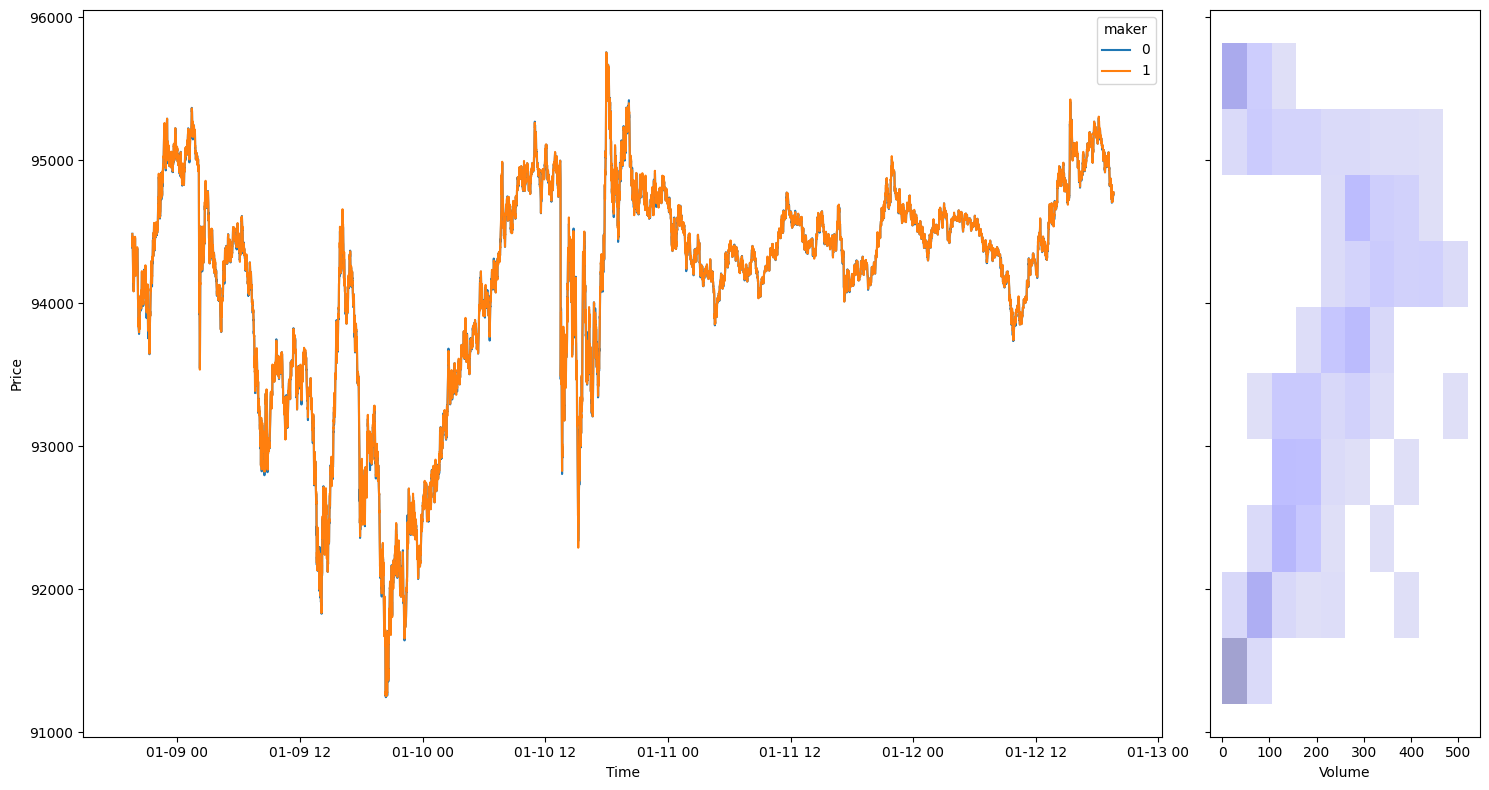

In [14]:
fig, (ax_line, ax_hist) = plt.subplots(
    1, 2, figsize=(15, 8), gridspec_kw={"width_ratios": [4, 1]}, sharey=True
)

# Left plot: time-series price line chart
sns.lineplot(data=dyn, x="timestamp", y="vwap", hue="maker", ax=ax_line)
ax_line.set_xlabel("Time")
ax_line.set_ylabel("Price")

# Right plot: horizontal barplot for volume profile
sns.histplot(
    data=vp,
    y="price_bucket",  # price level on the y-axis
    x="aggr_volume_total",  # total volume determines the length of each bar
    # orient="h",       # horizontal bars
    ax=ax_hist,
    color="blue",
    # hue="maker",
    alpha=0.5,
)
ax_hist.set_xlabel("Volume")
ax_hist.set_ylim(ax_line.get_ylim())  # Align y-axis with left plot
ax_hist.set_ylabel("")  # No duplicate y-label

plt.tight_layout()
plt.show()

In [18]:
a = timedelta(seconds=10) * 200
a

datetime.timedelta(seconds=2000)

In [19]:
# find days

a.total_seconds() / 60 / 60

0.5555555555555556

In [ ]:
# Ensure vp is sorted by price ascending (numeric)
vp = vp.sort("vwap")

# Confirm that the range of vp["vwap"] overlaps the dyn["vwap"] range
print("dyn vwap range:", dyn["vwap"].min(), dyn["vwap"].max())
print("vp vwap range:", vp["vwap"].min(), vp["vwap"].max())

# Optionally, if order is reversed, invert y-axis on the bar chart


In [ ]:
sns.lineplot(data=dyn, x="timestamp", y="vwap", hue="maker")

In [ ]:
import ccxt

print(ccxt.exchanges)  # print a list of all available exchange classes

In [ ]:
exchange = ccxt.binance()
symbol = "BTC/USDT"
timeframe = "1h"
since = exchange.parse8601("2022-01-01T00:00:00Z")
limit = 1000
all_data = []

while True:
    data = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
    if not data:
        break
    since = data[-1][0] + 1
    all_data += data

In [ ]:
all_data

In [ ]:
import polars as pl
import polars_talib as plta

df = pl.DataFrame(
    all_data,
    orient="row",
    schema=pl.Schema(
        {
            "timestamp": pl.Datetime(time_unit="ms"),
            "open": pl.Float64(),
            "high": pl.Float64(),
            "low": pl.Float64(),
            "close": pl.Float64(),
            "volume": pl.Float64(),
        }
    ),
)
df

In [ ]:
df = df.with_columns(
    plta.macd()
    .struct.rename_fields(["macd_line", "macd_signal", "macd_hist"])
    .struct.unnest(),
    plta.bbands(timeperiod=20)
    .struct.rename_fields(["bb_upper", "bb_basis", "bb_lower"])
    .struct.unnest(),
    plta.stoch().struct.rename_fields(["stoch_k", "stoch_d"]).struct.unnest(),
    ema_short=plta.ema(timeperiod=8),
    ema_long=plta.ema(timeperiod=21),
    rsi=plta.rsi(timeperiod=14),
    atr=plta.atr(timeperiod=14),
    sar=plta.sar(),
    adx=plta.adx(),
    adx_plus_di=plta.plus_di(),
    adx_minus_di=plta.minus_di(),
)

In [ ]:
def generate_signals(
    df: pl.DataFrame,
    rsi_overbought: float = 70,
    rsi_oversold: float = 30,
    min_adx: float = 25,
) -> pl.DataFrame:
    """
    Generate trading signals based on multiple technical indicators.

    Long Entry Conditions:
    1. EMA Short crosses above EMA Long (trend following)
    2. RSI is oversold (momentum)
    3. Price is near lower Bollinger Band (mean reversion)
    4. MACD histogram is positive (momentum confirmation)
    5. ADX > 25 (strong trend)
    6. Stochastic K line crosses above D line from oversold

    Short Entry Conditions:
    1. EMA Short crosses below EMA Long
    2. RSI is overbought
    3. Price is near upper Bollinger Band
    4. MACD histogram is negative
    5. ADX > 25
    6. Stochastic K line crosses below D line from overbought

    Exit Conditions:
    1. Take Profit: 2 * ATR from entry
    2. Stop Loss: 1 * ATR from entry
    3. Or opposite signal occurs
    """

    # Calculate crossovers
    df = df.with_columns(
        ema_crossover=(pl.col("ema_short") > pl.col("ema_long"))
        & (pl.col("ema_short").shift() <= pl.col("ema_long").shift()),
    )
    ema_crossover = (df["ema_short"] > df["ema_long"]) & (
        df["ema_short"].shift() <= df["ema_long"].shift()
    )

    ema_crossunder = (df["ema_short"] < df["ema_long"]) & (
        df["ema_short"].shift() >= df["ema_long"].shift()
    )

    # Stochastic crossovers
    stoch_crossover = (df["stoch_k"] > df["stoch_d"]) & (
        df["stoch_k"].shift() <= df["stoch_d"].shift()
    )

    stoch_crossunder = (df["stoch_k"] < df["stoch_d"]) & (
        df["stoch_k"].shift() >= df["stoch_d"].shift()
    )

    # Long entry conditions
    long_conditions = (
        ema_crossover  # Trend following
        & (df["rsi"] < rsi_oversold)  # Oversold
        & (df["close"] <= df["bb_lower"])  # Price near lower BB
        & (df["macd_hist"] > 0)  # Positive MACD histogram
        & (df["adx"] > min_adx)  # Strong trend
        & stoch_crossover  # Stochastic confirmation
    )

    # Short entry conditions
    short_conditions = (
        ema_crossunder  # Trend following
        & (df["rsi"] > rsi_overbought)  # Overbought
        & (df["close"] >= df["bb_upper"])  # Price near upper BB
        & (df["macd_hist"] < 0)  # Negative MACD histogram
        & (df["adx"] > min_adx)  # Strong trend
        & stoch_crossunder  # Stochastic confirmation
    )

    # Initialize signal series
    signals = pl.Series(np.zeros(len(df)))

    # Generate signals (1 for long, -1 for short, 0 for no position)
    signals = pl.Series(np.where(long_conditions, 1, np.where(short_conditions, -1, 0)))

    # Add signals to DataFrame
    result_df = df.with_columns([pl.Series("signal", signals)])

    return result_df


df.with_columns(
    ema_crossover=(pl.col("ema_short") > pl.col("ema_long"))
    & (pl.col("ema_short").shift() <= pl.col("ema_long").shift()),
    ema_crossunder=(pl.col("ema_short") < pl.col("ema_long"))
    & (pl.col("ema_short").shift() >= pl.col("ema_long").shift()),
    stoch_crossover=(pl.col("stoch_k") > pl.col("stoch_d"))
    & (pl.col("stoch_k").shift() <= pl.col("stoch_d").shift()),
    stoch_crossunder=(pl.col("stoch_k") < pl.col("stoch_d"))
    & (pl.col("stoch_k").shift() >= pl.col("stoch_d").shift()),
).with_columns(
    long_conditions=(
        pl.col("ema_crossover")  # Trend following
        & (pl.col("rsi") < 30)  # Oversold
        & (pl.col("close") <= pl.col("bb_lower"))  # Price near lower BB
        & (pl.col("macd_hist") > 0)  # Positive MACD histogram
        & (pl.col("adx") > 25)  # Strong trend
        & pl.col("stoch_crossover")  # Stochastic confirmation
    ),
    short_conditions=(
        pl.col("ema_crossunder")  # Trend following
        & (pl.col("rsi") > 70)  # Overbought
        & (pl.col("close") >= pl.col("bb_upper"))  # Price near upper BB
        & (pl.col("macd_hist") < 0)  # Negative MACD histogram
        & (pl.col("adx") > 25)  # Strong trend
        & pl.col("stoch_crossunder")  # Stochastic confirmation
    ),
).with_columns(
    signals=pl.when(pl.col("long_conditions"))
    .then(1)
    .when(pl.col("short_conditions"))
    .then(-1)
    .otherwise(0)
).describe()